In [1]:
import pandas as pd
import numpy as np
import re
import sklearn
#import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

In [3]:
#reading in the two tables
app = pd.read_csv('application_record.csv')
credit = pd.read_csv('credit_record.csv')

In [4]:
app.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [5]:
credit.head(5)

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [6]:
#merging the two tables by customer ID
total = pd.merge(app, credit, on='ID')
total.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-1,C
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-2,C
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-3,C
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-4,C


In [7]:
#change the status labels to good or bad (0|1)
#Here we will define that any late payment is bad
total['STATUS'] = total['STATUS'].replace(['C'],0)
total['STATUS'] = total['STATUS'].replace(['X'],0)
total['STATUS'] = total['STATUS'].apply(pd.to_numeric)
total['STATUS'] = np.where(total['STATUS'] <1, 0, 1)

total.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,0
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-1,0
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-2,0
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-3,0
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-4,0


In [8]:
group = total.groupby('ID')
series = group.apply(lambda x: x['STATUS'].unique())

In [9]:
temp = series.apply(pd.Series)
temp = temp.drop(0,axis=1)
# temp.head(5)

In [10]:
temp[1] = temp[1].fillna(0)
temp[1] = temp[1].astype(int)
temp.head(5)
temp2 = total

In [11]:
merged = pd.merge(temp2, temp, on='ID')
merged.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS,1
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,0,0,1
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,-1,0,1
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,-2,0,1
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,-3,0,1
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,-4,0,1


In [12]:
#dropping any duplicate rows
merged = merged.drop_duplicates('ID')
print(len(merged[(merged[1]>0)]))
merged = merged.drop(['STATUS'],axis=1)
merged = merged.rename(columns={1:'STATUS'})
merged.head(5)

3909


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,1
16,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,1
31,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0,0
61,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0,0
66,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-22,0


In [13]:
print(len(merged[(merged['STATUS']>-1)]))
print(len(total[(total['STATUS']>0)]))

36457
11575


In [14]:
total = merged

In [15]:
#change flag to numnerical 0,1
d1 = pd.get_dummies(total.CODE_GENDER)
total['CODE_GENDER'] = d1['M']

d2 = pd.get_dummies(total.FLAG_OWN_CAR)
total['FLAG_OWN_CAR'] = d2['Y']

d3 = pd.get_dummies(total.FLAG_OWN_REALTY)
total['FLAG_OWN_REALTY'] = d3['Y']

#total.head(5)

In [16]:
#converting professions into numeric values
#Here we will group similar occupations
total['OCCUPATION_TYPE'] = total['OCCUPATION_TYPE'].replace(['Managers','Realty agents','High skill tech staff'],5)
total['OCCUPATION_TYPE'] = total['OCCUPATION_TYPE'].replace(['Accountants','IT staff','Private service staff'],4)
total['OCCUPATION_TYPE'] = total['OCCUPATION_TYPE'].replace(['HR staff','Core staff','Laborers'],3)
total['OCCUPATION_TYPE'] = total['OCCUPATION_TYPE'].replace(['Security staff','Sales staff','Secretaries','Medicine staff','Drivers'],2)
total['OCCUPATION_TYPE'] = total['OCCUPATION_TYPE'].replace(['Waiters/barmen staff','Cleaning staff','Cooking staff','Low-skill Laborers'],1)
total['OCCUPATION_TYPE'] = total['OCCUPATION_TYPE'].apply(pd.to_numeric)

In [17]:
#converting education to numeric values
total['NAME_EDUCATION_TYPE'] = total['NAME_EDUCATION_TYPE'].replace(['Academic degree'],5)
total['NAME_EDUCATION_TYPE'] = total['NAME_EDUCATION_TYPE'].replace(['Higher education'],4)
total['NAME_EDUCATION_TYPE'] = total['NAME_EDUCATION_TYPE'].replace(['Incomplete higher'],3)
total['NAME_EDUCATION_TYPE'] = total['NAME_EDUCATION_TYPE'].replace(['Secondary / secondary special'],2)
total['NAME_EDUCATION_TYPE'] = total['NAME_EDUCATION_TYPE'].replace(['Lower secondary'],1)
total['NAME_EDUCATION_TYPE'] = total['NAME_EDUCATION_TYPE'].apply(pd.to_numeric)

In [18]:
#converting income type to numeric values
total['NAME_INCOME_TYPE'] = total['NAME_INCOME_TYPE'].replace(['Pensioner'],5)
total['NAME_INCOME_TYPE'] = total['NAME_INCOME_TYPE'].replace(['Commercial associate'],4)
total['NAME_INCOME_TYPE'] = total['NAME_INCOME_TYPE'].replace(['State servant'],3)
total['NAME_INCOME_TYPE'] = total['NAME_INCOME_TYPE'].replace(['Working'],2)
total['NAME_INCOME_TYPE'] = total['NAME_INCOME_TYPE'].replace(['Student'],1)
total['NAME_INCOME_TYPE'] = total['NAME_INCOME_TYPE'].apply(pd.to_numeric)

In [19]:
#convert housing to numeric values
total['NAME_HOUSING_TYPE'] = total['NAME_HOUSING_TYPE'].replace(['Office apartment'],6)
total['NAME_HOUSING_TYPE'] = total['NAME_HOUSING_TYPE'].replace(['Co-op apartment'],5)
total['NAME_HOUSING_TYPE'] = total['NAME_HOUSING_TYPE'].replace(['Rented apartment'],4)
total['NAME_HOUSING_TYPE'] = total['NAME_HOUSING_TYPE'].replace(['House / apartment'],3)
total['NAME_HOUSING_TYPE'] = total['NAME_HOUSING_TYPE'].replace(['Municipal apartment'],2)
total['NAME_HOUSING_TYPE'] = total['NAME_HOUSING_TYPE'].replace(['With parents'],1)
total['NAME_HOUSING_TYPE'] = total['NAME_HOUSING_TYPE'].apply(pd.to_numeric)

#total.head(5)

In [20]:
# convert family status
total['NAME_FAMILY_STATUS'] = total['NAME_FAMILY_STATUS'].replace(['Married'],1)
total['NAME_FAMILY_STATUS'] = total['NAME_FAMILY_STATUS'].replace(['Single / not married'],2)
total['NAME_FAMILY_STATUS'] = total['NAME_FAMILY_STATUS'].replace(['Civil marriage'],3)
total['NAME_FAMILY_STATUS'] = total['NAME_FAMILY_STATUS'].replace(['Separated'],4)
total['NAME_FAMILY_STATUS'] = total['NAME_FAMILY_STATUS'].replace(['Widow'],5)
#total.head(5)

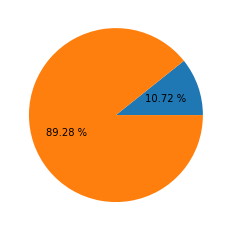

3909
32548


In [21]:
bad = total.loc[total['STATUS'] == 1].count()[0]
good = total.loc[total['STATUS'] == 0].count()[0]
plt.pie([bad,good],  autopct = '%.2f %%')
plt.show()
print(bad)
print(good)
#We can see that over 98% of data is good, will lead to overfitting

In [22]:
#drop id since we dont want ml model to use that
total = total.drop(columns=['ID'])
#also drop na rows
total = total.dropna()
#total.head(5)

In [23]:
total.head(5)

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
31,1,1,1,0,112500.0,2,2,1,3,-21474,-1134,1,0,0,0,2.0,2.0,0,0
61,0,0,1,0,270000.0,4,2,2,3,-19110,-3051,1,0,1,1,2.0,1.0,0,0
66,0,0,1,0,270000.0,4,2,2,3,-19110,-3051,1,0,1,1,2.0,1.0,-22,0
71,0,0,1,0,270000.0,4,2,2,3,-19110,-3051,1,0,1,1,2.0,1.0,0,0
98,0,0,1,0,270000.0,4,2,2,3,-19110,-3051,1,0,1,1,2.0,1.0,0,0


In [24]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [25]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler

x,y = total.loc[:,total.columns != 'STATUS'], total.loc[:,'STATUS']
rus = RandomUnderSampler(sampling_strategy=.35)
X_res, y_res = rus.fit_resample(x, y)

In [26]:
x_train,x_test,y_train,y_test = train_test_split(X_res,y_res,test_size = 0.20,random_state = 1)

In [27]:
len(x_train.index)

8664

In [57]:
#the uncertain function calculates and returns the index of most uncertain data point in the unknown category
def uncertain(classi, unknown):
#     print(type(classi))
#     index = np.argmin(np.abs(list(classi.decision_function(x_train.iloc[unknown])))) #this is for svm only
    prob = np.array(classi.predict_proba(x_train.iloc[unknown])) #for all other classifiers
    uncert = 1 - prob.max(axis=1)
    index = np.argmax(np.abs(uncert))
#     print(prob)
#     print(uncert)
#     print(classi.predict_proba(x_train.iloc[unknown]))
    return unknown[index]

In [58]:
length=len(x_train.index)
train_ind = list(range(5))
unknown_ind = list(range(5,length))
x_Rtrain = x_train.iloc[train_ind]
y_Rtrain = y_train.iloc[train_ind]

classi = BaggingClassifier()
classi.fit(x_Rtrain, y_Rtrain)
uncert = uncertain(classi, unknown_ind)
unknown_ind.remove(uncert)
y_pred = classi.predict(x_test)
classification = classification_report(y_test,y_pred)
print(classification)


              precision    recall  f1-score   support

           0       0.73      0.98      0.83      1581
           1       0.17      0.01      0.02       585

    accuracy                           0.72      2166
   macro avg       0.45      0.50      0.43      2166
weighted avg       0.58      0.72      0.62      2166



In [59]:
# Active training model
active_recall = []
active_perc = []
num = 10
it = 250
for j in range(it):
    for i in range(num):
        train_ind.append(uncert)
        x_Rtrain = x_train.iloc[train_ind]
        y_Rtrain = y_train.iloc[train_ind]
#         classi = DecisionTreeClassifier()
#         classi.fit(x_Rtrain, y_Rtrain)
        uncert = uncertain(classi, unknown_ind)
#         print(uncert)
        unknown_ind.remove(uncert)
    classi.fit(x_Rtrain, y_Rtrain)
    y_pred = classi.predict(x_test)
    classification = classification_report(y_test,y_pred,output_dict=True)
    active_recall.append(classification['1']['recall'])
    active_perc.append(classification['1']['precision'])
# print(classification)

In [60]:
print(active_recall[len(active_recall)-1])
print(max(active_recall))

0.24957264957264957
0.27008547008547007


In [61]:
x = np.array([*range(1,len(active_recall)+1, 1)])
active_recall_y = np.array(active_recall)
# print(len(x), len(y))
# plt.plot(active_y)
# plt.show()

In [62]:
x = np.array([*range(1,len(active_perc)+1, 1)])
active_accu_y = np.array(active_perc)
# print(len(x), len(y))
# plt.plot(y)
# plt.show()

In [63]:
#random selection model for comparison
import random
random_hist = []
random_perc = []
train_ind = list(range(5))
unknown_ind = list(range(5,length))
uncert = random.choice(unknown_ind)
for j in range(it):
    for i in range(num):
        train_ind.append(uncert)
        x_Rtrain = x_train.iloc[train_ind]
        y_Rtrain = y_train.iloc[train_ind]
#         classi = DecisionTreeClassifier()
        uncert = random.choice(unknown_ind)#instead of choosing the most uncertain one, now we are randomly choosing an index
#         print(uncert)
        unknown_ind.remove(uncert)
    classi.fit(x_Rtrain, y_Rtrain)
    y_pred = classi.predict(x_test)
    classification = classification_report(y_test,y_pred,output_dict=True)
    random_hist.append(classification['1']['recall'])
    random_perc.append(classification['1']['precision'])
# print(classification['1']['recall'])

In [64]:
print(random_hist[len(random_hist)-1])
print(max(random_hist))

0.28547008547008546
0.3145299145299145


In [65]:
x = np.array([*range(1,len(random_hist)+1, 1)])
random_recall_y = np.array(random_hist)
# print(len(x), len(y))
# plt.plot(random_y)
# plt.show()

In [66]:
x = np.array([*range(1,len(random_perc)+1, 1)])
random_accu_y = np.array(random_perc)
# print(len(x), len(y))
# plt.plot(y)
# plt.show()

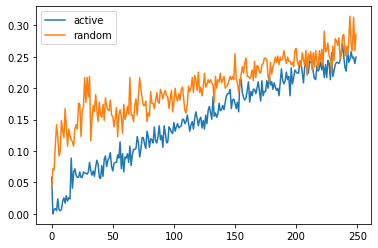

In [67]:
plt.plot(active_recall_y, label="active")
plt.plot(random_recall_y, label="random")
plt.legend()
# plt.savefig("%s recall.png"% (classi))
plt.show()

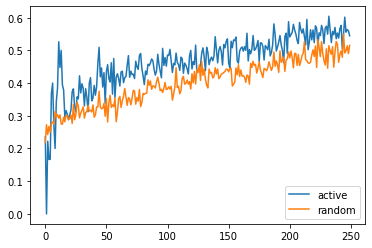

In [68]:
plt.plot(active_accu_y, label="active")
plt.plot(random_accu_y, label="random")
plt.legend()
# plt.savefig("%s accuracy.png"% (classi))
plt.show()

In [69]:
# models = {}
# # models['KNN'] = KNeighborsClassifier()
# # models['DecisionTree'] = DecisionTreeClassifier()
# models['svm'] = SVC()
# models['bayes'] = GaussianNB()
# models['RandomForest'] = RandomForestClassifier()
# models['LogisticRegression'] = LogisticRegression(max_iter=1000)
# models['ada'] = AdaBoostClassifier()
# models['gda'] = GradientBoostingClassifier()
# models['bca'] = BaggingClassifier()

In [70]:
# for name, model in models.items():
#     model.fit(x_train, y_train)
#     y_pred = model.predict(x_test)
#     classification = classification_report(y_test,y_pred)
#     print(name, classification)